In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report
from tensorflow.keras.models import Model

In [2]:
normal_df = pd.read_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\SWaT_Dataset_Normal_v0.csv')
attack_df = pd.read_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\SWaT_Dataset_Attack_v0.csv')

In [194]:
combined_df = pd.concat([normal_df, attack_df], ignore_index=True)

In [195]:
print(combined_df.shape)
combined_df.head()

(946719, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


In [196]:
mode = combined_df["Normal/Attack"].mode()[0]
combined_df["Normal/Attack"].fillna(mode, inplace=True)

combined_df['Normal/Attack'] = combined_df['Normal/Attack'].replace('A ttack', 'Attack')
combined_df['Normal/Attack'].unique()

array(['Normal', 'Attack'], dtype=object)

In [7]:
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

combined_df['Normal/Attack'] = label_encoder.fit_transform(combined_df['Normal/Attack'])

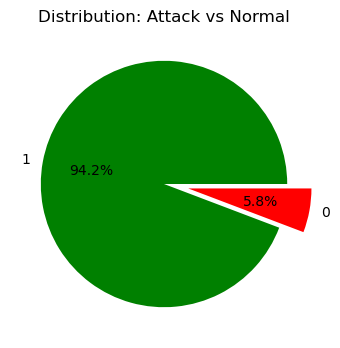

In [8]:
class_distribution = combined_df['Normal/Attack'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(class_distribution, labels=class_distribution.index, explode=[0, 0.2], autopct='%1.1f%%', colors=['g', 'r'])
plt.title('Distribution: Attack vs Normal')
plt.show()

In [197]:
combined_df.isna().sum()

Timestamp        0
FIT101           0
LIT101           0
MV101            0
P101             0
P102             0
AIT201           0
AIT202           0
AIT203           0
FIT201           0
MV201            0
P201             0
P202             0
P203             0
P204             0
P205             0
P206             0
DPIT301          0
FIT301           0
LIT301           0
MV301            0
MV302            0
MV303            0
MV304            0
P301             0
P302             0
AIT401           0
AIT402           0
FIT401           0
LIT401           0
P401             0
P402             0
P403             0
P404             0
UV401            0
AIT501           0
AIT502           0
AIT503           0
AIT504           0
FIT501           0
FIT502           0
FIT503           0
FIT504           0
P501             0
P502             0
PIT501           0
PIT502           0
PIT503           0
FIT601           0
P601             0
P602             0
P603             0
Normal/Attac

In [198]:
combined_df['Timestamp'] = combined_df['Timestamp'].str.strip()

combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])

C:\Users\Asus\AppData\Local\Temp\ipykernel_21492\1839715018.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])


In [199]:
combined_df = combined_df.set_index('Timestamp')

In [200]:
combined_df.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2015-12-22 16:00:02,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2015-12-22 16:00:03,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2015-12-22 16:00:04,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,2,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


###### do not compile following 2 rows

In [13]:
#remove dublicate features
def find_duplicate_features(df):
    duplicates = {}
    cols = df.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if df[cols[i]].equals(df[cols[j]]):
                duplicates.setdefault(cols[i], []).append(cols[j])
    return duplicates

In [15]:
duplicate_features = find_duplicate_features(combined_df.select_dtypes(include=[np.number]))
for original, dupes in duplicate_features.items():
    combined_df.drop(columns=dupes, inplace=True)

In [188]:
combined_df = combined_df.loc[:, combined_df.nunique() > 1]

In [203]:
combined_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.190080,306.1010,2.471278,2,...,1,1,10.02948,0.000000,4.277749,0.000256,1,1,1,0
2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.190080,306.1010,2.468587,2,...,1,1,10.02948,0.000000,4.277749,0.000256,1,1,1,0
2015-12-22 16:00:02,2.439548,260.9131,2,2,1,244.3284,8.190080,306.1010,2.467305,2,...,1,1,10.02948,0.000000,4.277749,0.000256,1,1,1,0
2015-12-22 16:00:03,2.428338,260.2850,2,2,1,244.3284,8.190080,306.1010,2.466536,2,...,1,1,10.02948,0.000000,4.277749,0.000256,1,1,1,0
2015-12-22 16:00:04,2.424815,259.8925,2,2,1,244.4245,8.190080,306.1010,2.466536,2,...,1,1,10.02948,0.000000,4.277749,0.000256,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-01 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.15350,0.865024,189.022000,0.000000,1,1,1,0
2016-02-01 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.07340,0.865024,188.925900,0.000000,1,1,1,0
2016-02-01 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.07340,0.865024,188.925900,0.000000,1,1,1,0


In [202]:
# Convert "Normal/Attack" column to binary
combined_df['Normal/Attack'] = combined_df['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)

### Visualization of SWaT Dataset

In [17]:
#only for visualization used

features_for_correlation = combined_df.drop(columns=['Normal/Attack'])

# Convert categorical features to numeric using label encoding or one-hot encoding
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in features_for_correlation.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    features_for_correlation[column] = le.fit_transform(features_for_correlation[column])
    label_encoders[column] = le  # Store the label encoder for inverse_transform if needed

# Calculate the correlation matrix
correlation_matrix = features_for_correlation.corr()

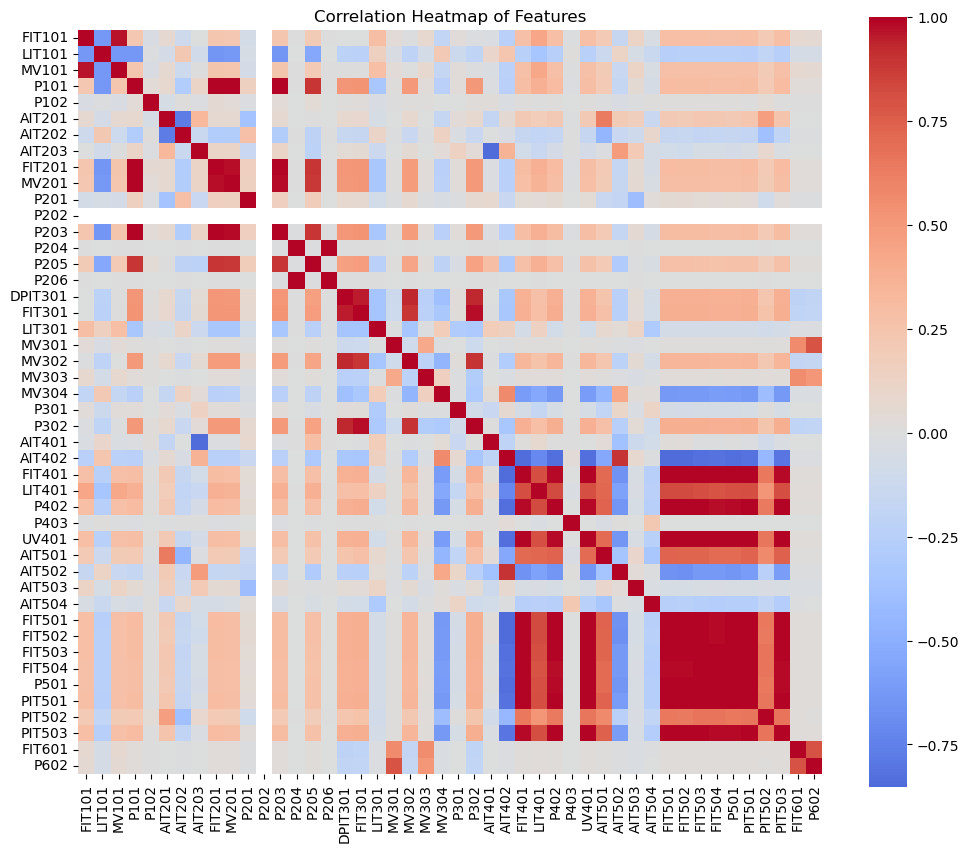

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Features')
plt.show()

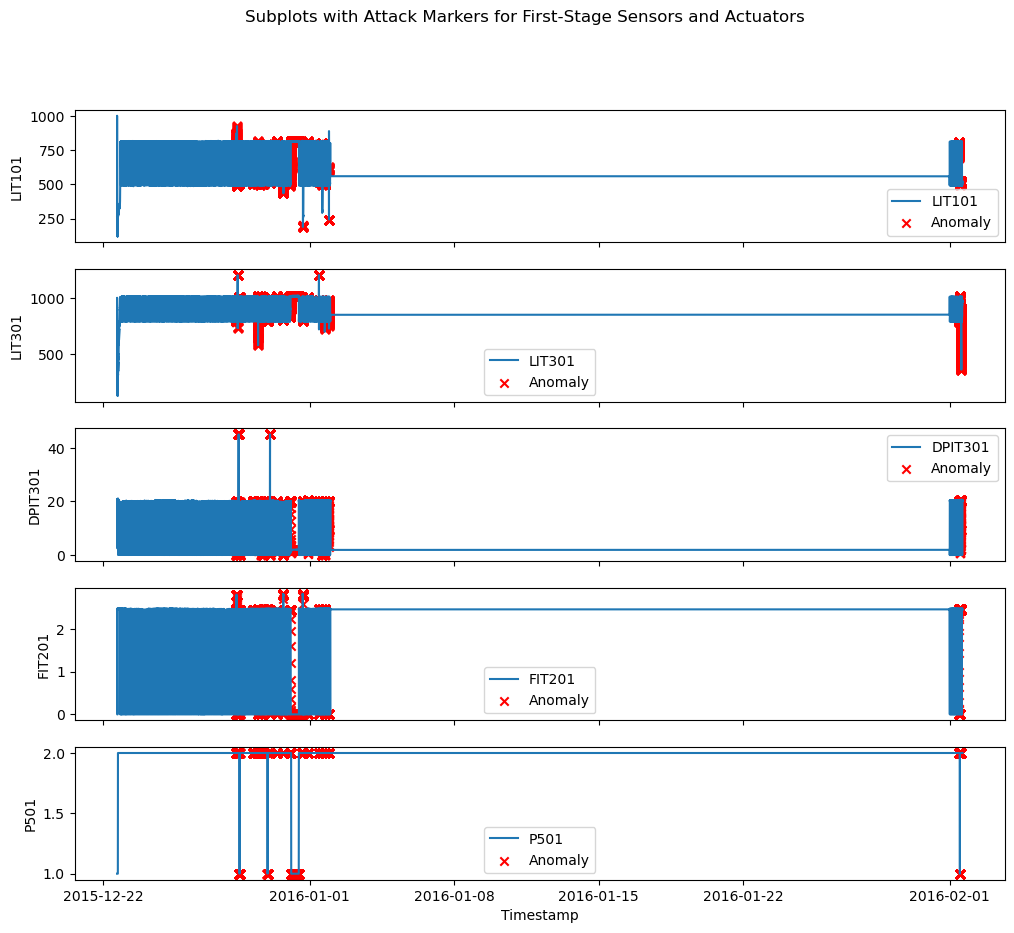

In [23]:
# List of all sensors and actuators in the first stage
first_stage_features = ['LIT101', 'LIT301', 'DPIT301', 'FIT201', 'P501']

# Number of features
num_features = len(first_stage_features)

# Create subplots
fig, axes = plt.subplots(num_features, 1, figsize=(12, 2 * num_features), sharex=True)

# Plot each feature in a separate subplot
for i, feature in enumerate(first_stage_features):
    axes[i].plot(combined_df.index, combined_df[feature], label=feature)
    axes[i].scatter(attack_data.index, attack_data[feature], color='red', marker='x', label='Anomaly')
    axes[i].set_ylabel(feature)
    axes[i].legend()

plt.xlabel('Timestamp')
plt.suptitle('Subplots with Attack Markers for First-Stage Sensors and Actuators')
plt.show()

## Data Preprocessing

In [26]:
# Calculate variance for each feature
numeric_columns = combined_df.select_dtypes(include=[np.number]).columns
feature_variances = combined_df[numeric_columns].var()

# Filter out features with very low variance (set a threshold, e.g., variance < some_value)
low_variance_features = feature_variances[feature_variances < 0.01].index.tolist()
print("Low variance features:", low_variance_features)

features_to_remove = set(low_variance_features)
filtered_df = combined_df.drop(columns=list(features_to_remove))

Low variance features: ['P102', 'P202', 'P204', 'P206', 'P301', 'P403', 'AIT501', 'FIT504', 'P602']


In [204]:
# start running from this
# Remove duplicate rows
combined_df.drop_duplicates(inplace=True)

# Drop missing values
combined_df.dropna(inplace=True)

combined_df.shape

(928898, 52)

In [206]:
combined_df.nunique()

FIT101            3953
LIT101           12162
MV101                3
P101                 2
P102                 2
AIT201            2338
AIT202            1763
AIT203            6868
FIT201            4989
MV201                3
P201                 2
P202                 1
P203                 2
P204                 2
P205                 2
P206                 2
DPIT301           5180
FIT301            8281
LIT301           11966
MV301                3
MV302                3
MV303                3
MV304                3
P301                 2
P302                 2
AIT401              37
AIT402            4127
FIT401             968
LIT401           15141
P401                 1
P402                 2
P403                 2
P404                 1
UV401                2
AIT501            1724
AIT502            3470
AIT503            1123
AIT504             565
FIT501            1027
FIT502            1560
FIT503             499
FIT504             289
P501                 2
P502       

In [207]:
combined_df = combined_df.loc[:, combined_df.nunique() > 1]

In [208]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 928898 entries, 2015-12-22 16:00:00 to 2016-02-01 14:59:59
Data columns (total 46 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIT101         928898 non-null  float64
 1   LIT101         928898 non-null  float64
 2   MV101          928898 non-null  int64  
 3   P101           928898 non-null  int64  
 4   P102           928898 non-null  int64  
 5   AIT201         928898 non-null  float64
 6   AIT202         928898 non-null  float64
 7   AIT203         928898 non-null  float64
 8   FIT201         928898 non-null  float64
 9   MV201          928898 non-null  int64  
 10  P201           928898 non-null  int64  
 11  P203           928898 non-null  int64  
 12  P204           928898 non-null  int64  
 13  P205           928898 non-null  int64  
 14  P206           928898 non-null  int64  
 15  DPIT301        928898 non-null  float64
 16  FIT301         928898 non-null  float64


In [209]:
# changing "Normal/Attack" features name
combined_df["anomaly"] = combined_df["Normal/Attack"]
anomaly = combined_df.anomaly
combined_df.drop(["Normal/Attack"], axis=1, inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_21492\2782688551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["anomaly"] = combined_df["Normal/Attack"]
C:\Users\Asus\AppData\Local\Temp\ipykernel_21492\2782688551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df.drop(["Normal/Attack"], axis=1, inplace=True)


In [211]:
combined_df.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,2,...,0.001409,0.001664,0.0,1,10.02948,0.0,4.277749,0.000256,1,0
2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,2,...,0.001409,0.001664,0.0,1,10.02948,0.0,4.277749,0.000256,1,0
2015-12-22 16:00:02,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,2,...,0.001409,0.001664,0.0,1,10.02948,0.0,4.277749,0.000256,1,0
2015-12-22 16:00:03,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,2,...,0.001409,0.001664,0.0,1,10.02948,0.0,4.277749,0.000256,1,0
2015-12-22 16:00:04,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,2,...,0.001409,0.001664,0.0,1,10.02948,0.0,4.277749,0.000256,1,0


In [215]:
# input & output values are defined X & y
X = combined_df.drop('anomaly', axis=1)
y= combined_df['anomaly']
y = y.reset_index(drop=True)

In [216]:
y

0         0
1         0
2         0
3         0
4         0
         ..
928893    0
928894    0
928895    0
928896    0
928897    0
Name: anomaly, Length: 928898, dtype: int64

In [217]:
# Saparate Numerical and categorical features
numerical_features = []
categorical_features = []

for column in X.columns:
    unique_values = X[column].nunique()
    if unique_values > 10:
        numerical_features.append(column)
    else:
        categorical_features.append(column)
        
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
Categorical Features: ['MV101', 'P101', 'P102', 'MV201', 'P201', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']


### Normalization of data around [0,1]

In [219]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

numerical_data = combined_df[numerical_features]
categorical_data = combined_df[categorical_features]

# Min-Max scaling for numerical features
scaler = MinMaxScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=numerical_data.columns)

In [220]:
numerical_data_scaled_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
0,0.894987,0.160292,0.730144,0.732892,0.073596,0.874201,0.462186,0.940694,0.182199,0.000000,...,0.358411,0.012283,0.000948,0.001035,0.002179,0.000000,0.004448,0.000000,0.005921,0.000142
1,0.890230,0.159845,0.730144,0.732892,0.073596,0.873249,0.462186,0.940371,0.182199,0.000000,...,0.358411,0.012283,0.000948,0.001035,0.002179,0.000000,0.004448,0.000000,0.005921,0.000142
2,0.883848,0.159533,0.730144,0.732892,0.073596,0.872796,0.463182,0.939886,0.182199,0.000000,...,0.358411,0.012283,0.000948,0.001035,0.002179,0.000000,0.004448,0.000000,0.005921,0.000142
3,0.879786,0.158819,0.730144,0.732892,0.073596,0.872524,0.463182,0.939886,0.182049,0.000000,...,0.358411,0.012283,0.000948,0.001035,0.002179,0.000000,0.004448,0.000000,0.005921,0.000142
4,0.878510,0.158372,0.731064,0.732892,0.073596,0.872524,0.463182,0.939886,0.181936,0.000000,...,0.358411,0.012283,0.000948,0.001035,0.002179,0.000000,0.004448,0.000000,0.005921,0.000142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928893,0.927477,0.453646,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.788004,0.999645,...,0.233640,0.017144,0.976521,0.946393,0.962280,0.967064,0.947253,0.235808,0.941196,0.000000
928894,0.923532,0.454628,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.788041,0.999645,...,0.233640,0.017144,0.975427,0.934449,0.962280,0.967064,0.946940,0.235808,0.940709,0.000000
928895,0.917150,0.454941,0.000613,0.883013,0.058786,0.870257,0.451800,0.923981,0.787742,0.999645,...,0.233640,0.017144,0.975427,0.932098,0.962280,0.967064,0.946940,0.235808,0.940709,0.000000
928896,0.913437,0.454985,0.000613,0.883013,0.058786,0.870257,0.451018,0.923981,0.787704,0.999645,...,0.233640,0.017144,0.975427,0.927960,0.962280,0.971509,0.946940,0.235808,0.940709,0.000000


In [221]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(categorical_data)

categorical_feature_names = encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = encoder.transform(categorical_data)
categorical_data_encoded_df = pd.DataFrame(categorical_data_encoded, columns=categorical_feature_names)

In [222]:
categorical_data_encoded_df.head()

,MV101_1,MV101_2,P101_2,P102_2,MV201_1,MV201_2,P201_2,P203_2,P204_2,P205_2,...,MV303_2,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [234]:
preprocessed_data = pd.concat([numerical_data_scaled_df, categorical_data_encoded_df,y], axis=1)

preprocessed_data

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,anomaly
0,0.894987,0.160292,0.730144,0.732892,0.073596,0.874201,0.462186,0.940694,0.182199,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.890230,0.159845,0.730144,0.732892,0.073596,0.873249,0.462186,0.940371,0.182199,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.883848,0.159533,0.730144,0.732892,0.073596,0.872796,0.463182,0.939886,0.182199,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.879786,0.158819,0.730144,0.732892,0.073596,0.872524,0.463182,0.939886,0.182049,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.878510,0.158372,0.731064,0.732892,0.073596,0.872524,0.463182,0.939886,0.181936,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928893,0.927477,0.453646,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.788004,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928894,0.923532,0.454628,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.788041,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928895,0.917150,0.454941,0.000613,0.883013,0.058786,0.870257,0.451800,0.923981,0.787742,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928896,0.913437,0.454985,0.000613,0.883013,0.058786,0.870257,0.451018,0.923981,0.787704,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0


In [235]:
preprocessed_data.to_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\preprocessed_data.csv',index=False)

### Saving Data in saparated .csv file after pre-processing
start running from here

In [3]:
swat_prep = pd.read_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\preprocessed_data.csv')

In [7]:
swat_prep

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,anomaly
0,0.894987,0.160292,0.730144,0.732892,0.073596,0.874201,0.462186,0.940694,0.182199,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.890230,0.159845,0.730144,0.732892,0.073596,0.873249,0.462186,0.940371,0.182199,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.883848,0.159533,0.730144,0.732892,0.073596,0.872796,0.463182,0.939886,0.182199,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.879786,0.158819,0.730144,0.732892,0.073596,0.872524,0.463182,0.939886,0.182049,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.878510,0.158372,0.731064,0.732892,0.073596,0.872524,0.463182,0.939886,0.181936,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928893,0.927477,0.453646,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.788004,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928894,0.923532,0.454628,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.788041,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928895,0.917150,0.454941,0.000613,0.883013,0.058786,0.870257,0.451800,0.923981,0.787742,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0
928896,0.913437,0.454985,0.000613,0.883013,0.058786,0.870257,0.451018,0.923981,0.787704,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0


In [5]:
sensors=['FIT101','LIT101']

## Experimenting (will be deleted)

In [229]:
X = swat_prep

In [6]:
X = swat_prep.drop(columns=['anomaly'])
y = swat_prep['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 51)
Test data shape: (185780, 51)


In [165]:
#try it later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743112, 2)
Test data shape: (185779, 2)


Baseline AutoEncoder

In [173]:
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

In [174]:
model.fit(X_train)

IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [175]:
predictions = model.predict(X_test)

binary_predictions = [1 if pred == -1 else 0 for pred in predictions]

true_labels = y_test
predicted_labels = binary_predictions

In [176]:
accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.05849930024760469
Confusion Matrix:
[[ 4966   453]
 [87003   468]]
Precision: 0.50814332247557
Recall: 0.0053503446856672495
F1 Score: 0.010589193592180288
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.92      0.10      5419
           1       0.51      0.01      0.01     87471

    accuracy                           0.06     92890
   macro avg       0.28      0.46      0.06     92890
weighted avg       0.48      0.06      0.02     92890



### Sampling Dataset

In [239]:
X=swat_prep

In [240]:
sampled_data = X.sample(n=5000, random_state=42)
sampled_data = sampled_data.astype(np.float64)

In [241]:
sampled_data

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV304_1,MV304_2,P301_2,P302_2,P402_2,P403_2,UV401_2,P501_2,P602_2,anomaly
693046,0.906359,0.432890,0.283962,0.841836,0.152735,0.864228,0.441343,0.927162,0.670225,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
916789,0.000000,0.456637,0.018093,0.900598,0.021079,0.000000,0.040407,0.000000,0.822014,0.999645,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
292515,0.876537,0.774854,0.972707,0.812241,0.116664,0.000000,0.050010,0.000000,0.821339,0.999677,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
738953,0.000000,0.788022,0.241644,0.853953,0.279665,0.000000,0.045173,0.000000,0.825464,0.999677,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
748096,0.931422,0.438559,0.198099,0.834545,0.285117,0.866177,0.443548,0.927647,0.734383,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387542,0.949292,0.447799,0.942349,0.795513,0.155733,0.866132,0.441129,0.933147,0.751782,0.999645,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
502858,0.895916,0.477572,0.909843,0.795620,0.151190,0.863457,0.056911,0.029437,0.804465,0.999677,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
666151,0.000000,0.671609,0.453849,0.831114,0.154279,0.872388,0.436576,0.928133,0.625491,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
881908,0.878510,0.707319,0.110703,0.899526,0.021897,0.000000,0.449595,0.926515,0.710722,0.999677,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [242]:
X_sampled = sampled_data.drop(columns=['anomaly'])
y_sampled = sampled_data['anomaly']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

### Isolation Forest with sampled data

In [243]:
iso_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
iso_model.fit(X_train_s)

IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [244]:
iso_predictions = iso_model.predict(X_test_s)

iso_binary_predictions = [1 if pred == -1 else 0 for pred in iso_predictions]

iso_true_labels = y_test_s
iso_predicted_labels = iso_binary_predictions

In [245]:
accuracy = accuracy_score(iso_true_labels, iso_predicted_labels)
confusion = confusion_matrix(iso_true_labels, iso_predicted_labels)
precision = precision_score(iso_true_labels, iso_predicted_labels)
recall = recall_score(iso_true_labels, iso_predicted_labels)
f1 = f1_score(iso_true_labels, iso_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(iso_true_labels, iso_predicted_labels))

Accuracy: 0.924
Confusion Matrix:
[[922   6]
 [ 70   2]]
Precision: 0.25
Recall: 0.027777777777777776
F1 Score: 0.05
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       928
         1.0       0.25      0.03      0.05        72

    accuracy                           0.92      1000
   macro avg       0.59      0.51      0.51      1000
weighted avg       0.88      0.92      0.89      1000



### AutoEncoder with sampled data

In [246]:
input_shape = X_train_s.shape[1]
input_data = Input(shape=(input_shape,))
encoded = Dense(32, activation="relu")(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Decoding layer
decoded = Dense(input_shape, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

autoencoder_train=autoencoder.fit(X_train_s, X_train_s,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_s, X_test_s),callbacks=[early_stopping],verbose=1)

y_pred = autoencoder.predict(X_test_s)
mse = np.mean(np.power(X_test_s - y_pred, 2), axis=1)
y_predictions = y_pred[:, 0]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 51)             │         1,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,475 (13.57 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2308 - val_loss: 0.1773
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2057 - val_loss: 0.1533
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1832 - val_loss: 0.1295
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1650 - val_loss: 0.1080
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1476 - val_loss: 0.0900
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1315 - val_loss: 0.0764
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1139 - val_loss: 0.0664
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0991 - val_loss: 0.0588
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0860 - val_loss: 0.0544
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0751 - val_loss: 0.0509
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0660 - val_loss: 0.0478
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [247]:
threshold = np.percentile(mse, 95.5)

y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test_s, y_pred)
conf_matrix = confusion_matrix(y_test_s, y_pred)
precision = precision_score(y_test_s, y_pred)
recall = recall_score(y_test_s, y_pred)
f1 = f1_score(y_test_s, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test_s, y_pred))

Accuracy: 0.961
Confusion Matrix:
[[922   6]
 [ 33  39]]
Precision: 0.8666666666666667
Recall: 0.5416666666666666
F1-score: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       928
         1.0       0.87      0.54      0.67        72

    accuracy                           0.96      1000
   macro avg       0.92      0.77      0.82      1000
weighted avg       0.96      0.96      0.96      1000



# Baseline for all data
###### splitting data to train and test sets 80-20%

In [54]:
X = swat_prep.drop(columns=['anomaly'])
y = swat_prep['anomaly']

df_train = X.iloc[:700000, :]
df_test = X.iloc[700000:, :]
target_train = y.iloc[:700000]
target_test = y.iloc[700000:]

print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

Training data shape: (700000, 51)
Test data shape: (228898, 51)


### Isolation Forest Baseline

In [12]:
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

In [13]:
model.fit(df_train)

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [32]:
predictions = model.predict(df_test)

binary_predictions = [1 if pred == -1 else 0 for pred in predictions]

true_labels = target_test
predicted_labels = binary_predictions

In [34]:
from sklearn.metrics import make_scorer, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.9459453555732248
Confusion Matrix:
[[184552   2244]
 [ 10129  31973]]
Precision: 0.9344185638717597
Recall: 0.759417604864377
F1 Score: 0.8378778547936949
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    186796
           1       0.93      0.76      0.84     42102

    accuracy                           0.95    228898
   macro avg       0.94      0.87      0.90    228898
weighted avg       0.95      0.95      0.94    228898



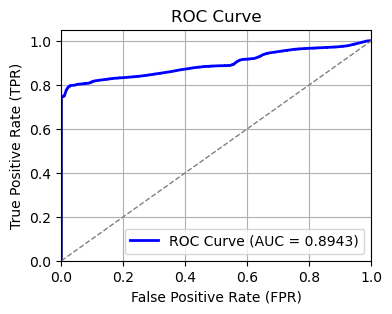

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assume `model` is your trained Isolation Forest model and `df_test` is your test dataset
# Get anomaly scores using decision_function
anomaly_scores = model.decision_function(df_test)

# Invert the scores for ROC computation: higher scores should indicate anomalies
# Isolation Forest outputs negative scores for anomalies, so invert by multiplying by -1
fpr, tpr, thresholds = roc_curve(true_labels, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [16]:
from joblib import dump

# Save the Isolation Forest model
dump(model, r'C:\Users\Asus\Downloads\Thesis\models\new\isolation_forest_model.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\new\\isolation_forest_model.joblib']

### AutoEncoder Baseline

In [17]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

input_shape = df_train.shape[1]

# Define the encoding layer
input_data = Input(shape=(input_shape,))
encoded = Dense(32, activation="relu")(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Decoding layer
decoded = Dense(input_shape, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)


autoencoder_train=autoencoder.fit(df_train, df_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(df_test, df_test),callbacks=[early_stopping],verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 51)             │         1,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,475 (13.57 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0502 - val_loss: 0.0113
Epoch 2/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0060 - val_loss: 0.0106
Epoch 3/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0051 - val_loss: 0.0140
Epoch 4/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0046 - val_loss: 0.0146
Epoch 5/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0044 - val_loss: 0.0136
Epoch 6/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0042 - val_loss: 0.0134
Epoch 7/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0040 - val_loss: 0.0135


In [18]:
y_pred = autoencoder.predict(df_test)
mse = np.mean(np.power(df_test - y_pred, 2), axis=1)

7154/7154 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [22]:
threshold = np.percentile(mse, 85)

y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(target_test, y_pred)
conf_matrix = confusion_matrix(target_test, y_pred)


precision = precision_score(target_test, y_pred)
recall = recall_score(target_test, y_pred)
f1 = f1_score(target_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(target_test, y_pred))

Accuracy: 0.9462249560939807
Confusion Matrix:
[[184525   2271]
 [ 10038  32064]]
Precision: 0.9338575797291394
Recall: 0.761579022374234
F1-score: 0.838965422504808
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    186796
           1       0.93      0.76      0.84     42102

    accuracy                           0.95    228898
   macro avg       0.94      0.87      0.90    228898
weighted avg       0.95      0.95      0.94    228898



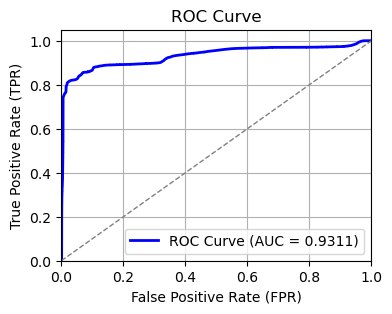

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(target_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [26]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(target_test, mse)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]

print(f"Optimal threshold by F1-score: {optimal_threshold}")
print(f"Maximum F1-score: {f1_scores[max_f1_index]}")

Optimal threshold by F1-score: 0.020860603838294446
Maximum F1-score: 0.8540002257534522


C:\Users\Asus\AppData\Local\Temp\ipykernel_8580\1124347650.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [27]:
y_pred_class = (mse > optimal_threshold).astype(int)

In [29]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(target_test, y_pred_class, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.9047
Recall: 0.8086
F1 Score: 0.8540


In [25]:
threshold

0.02406686991735924

In [31]:
autoencoder.save(r'C:\Users\Asus\Downloads\Thesis\models\new\autoencoder_model.keras')

### LSTM Baseline

In [37]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
timesteps = 30
X_sequences = []
y_sequences = []

In [39]:
for i in range(len(X_scaled) - timesteps):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y.iloc[i+timesteps])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [40]:
train_size = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

In [41]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

In [43]:
model.compile(optimizer='adam', loss='mse')
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 51)         │         3,315 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,579 (306.95 KB)

 Trainable params: 78,579 (306.95 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 267s 111ms/step - loss: 0.5970 - val_loss: 0.0606
Epoch 2/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 234s 101ms/step - loss: 0.0191 - val_loss: 0.0494
Epoch 3/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 229s 98ms/step - loss: 0.0141 - val_loss: 0.0389
Epoch 4/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 249s 107ms/step - loss: 0.0128 - val_loss: 0.0479
Epoch 5/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 249s 107ms/step - loss: 0.0133 - val_loss: 0.0380
Epoch 6/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 243s 105ms/step - loss: 0.0100 - val_loss: 0.0334
Epoch 7/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 246s 106ms/step - loss: 0.0117 - val_loss: 0.0335
Epoch 8/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 244s 105ms/step - loss: 0.0079 - val_loss: 0.0274
Epoch 9/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 255s 110ms/step - loss: 0.0079 - val_loss: 0.0279
Epoch 10/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 268s 115ms/step - loss: 0.0083 - val_loss: 0.0517
Epoch 11/50
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 272s 117ms/step - loss: 0.0069 - val_

In [45]:
X_test_pred = model.predict(X_test)

5806/5806 ━━━━━━━━━━━━━━━━━━━━ 68s 12ms/step


In [48]:
reconstruction_errors = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))

threshold = np.percentile(reconstruction_errors, 95)

y_pred = (reconstruction_errors > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9489864028335504
Confusion Matrix:
[[171509   4501]
 [  4976   4788]]
Precision: 0.5154483798040693
Recall: 0.4903727980335928
F1-score: 0.502598016060463
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    176010
           1       0.52      0.49      0.50      9764

    accuracy                           0.95    185774
   macro avg       0.74      0.73      0.74    185774
weighted avg       0.95      0.95      0.95    185774



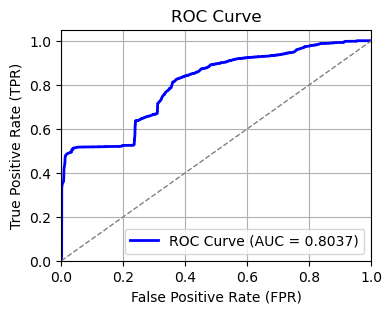

In [52]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [49]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_errors)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]

print(f"Optimal threshold by F1-score: {optimal_threshold}")
print(f"Maximum F1-score: {f1_scores[max_f1_index]}")

Optimal threshold by F1-score: 0.04629181527033932
Maximum F1-score: 0.5595817559040923


C:\Users\Asus\AppData\Local\Temp\ipykernel_8580\3020394632.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [51]:
y_pred_class = (reconstruction_errors > optimal_threshold).astype(int)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.6770
Recall: 0.4768
F1 Score: 0.5595


In [53]:
model.save(r'C:\Users\Asus\Downloads\Thesis\models\new\lstm_model.keras')

### OCSVM Baseline

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 51)
Test data shape: (185780, 51)


In [56]:
from sklearn.svm import OneClassSVM

In [57]:
ocsvm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # nu is roughly the proportion of outliers

normal_data_train = X_train[y_train == 0]
ocsvm_model.fit(normal_data_train)

OneClassSVM(gamma='auto', nu=0.01)

In [61]:
from joblib import load
ocsvm_model_=load(r'C:\Users\Asus\Downloads\Thesis\models\new\basic_ocsvm_model.joblib')

In [65]:
ocsvm_predictions = ocsvm_model_.predict(X_test)
ocsvm_binary_predictions = [0 if pred == 1 else 1 for pred in ocsvm_predictions]

ocsvm_true_labels = y_test
ocsvm_predicted_labels = ocsvm_binary_predictions
accuracy = accuracy_score(ocsvm_true_labels, ocsvm_predicted_labels)
confusion = confusion_matrix(ocsvm_true_labels, ocsvm_predicted_labels)
precision = precision_score(ocsvm_true_labels, ocsvm_predicted_labels)
recall = recall_score(ocsvm_true_labels, ocsvm_predicted_labels)
f1 = f1_score(ocsvm_true_labels, ocsvm_predicted_labels)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(ocsvm_true_labels, ocsvm_predicted_labels))

Accuracy: 0.9706696092152007
Confusion Matrix:
[[173367   1685]
 [  3764   6964]]
Precision: 0.8051797895710486
Recall: 0.6491424310216256
F1 Score: 0.7187903184187439
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    175052
           1       0.81      0.65      0.72     10728

    accuracy                           0.97    185780
   macro avg       0.89      0.82      0.85    185780
weighted avg       0.97      0.97      0.97    185780



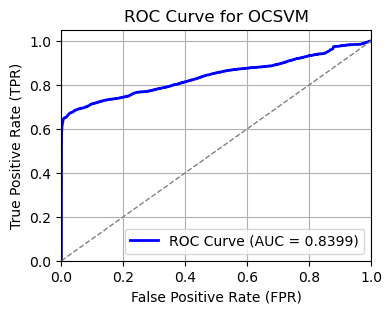

In [68]:
decision_scores = ocsvm_model_.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -decision_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for OCSVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()